In [1]:
import warnings

warnings.filterwarnings('ignore')

from pathlib import Path
from time import time
import datetime
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')
np.random.seed(42)
DATA_DIR = Path('data')

In [2]:
data = pd.read_hdf('data/backtest.h5', 'data')
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 190451 entries, ('AAPL', Timestamp('2014-12-09 00:00:00')) to ('LNG', Timestamp('2017-11-30 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   predicted  74054 non-null   float64
 1   open       190451 non-null  float64
 2   high       190451 non-null  float64
 3   low        190451 non-null  float64
 4   close      190451 non-null  float64
 5   volume     190451 non-null  float64
dtypes: float64(6)
memory usage: 10.2+ MB


In [3]:
pd.concat([data.head(), data.tail()])

predicted        open        high         low       close  \
ticker date                                                                    
AAPL   2014-12-09  -0.001594  104.680961  108.585478  103.882957  108.414477   
       2014-12-10  -0.000901  108.689978  109.107980  105.963466  106.352968   
       2014-12-11  -0.001059  106.647469  108.110476  105.773466  106.039467   
       2014-12-12  -0.000759  104.937462  106.276968  104.101458  104.243959   
       2014-12-15  -0.001041  105.165463  106.020467  101.032945  102.814203   
LNG    2017-11-24        NaN   47.520000   48.410000   47.520000   47.960000   
       2017-11-27        NaN   48.000000   48.210000   46.955000   47.190000   
       2017-11-28        NaN   47.520000   47.640000   46.960000   47.600000   
       2017-11-29        NaN   47.750000   48.130000   46.890000   48.000000   
       2017-11-30        NaN   48.000000   48.890000   48.000000   48.320000   

                       volume  
ticker date                    
AAPL   2014-12-09  60208036.0  
       2014-12-10  44565318.0  
       2014-12-11  41471578.0  
       2014-12-12  56028138.0  
       2014-12-15  67218082.0  
LNG    2017-11-24    697313.0  
       2017-11-27   1060879.0  
       2017-11-28   1170273.0  
       2017-11-29   1398839.0  
       2017-11-30   1862026.0

In [4]:
sp500 = web.DataReader('SP500', 'fred', '2014', '2018').pct_change()
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1044 entries, 2014-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   1042 non-null   float64
dtypes: float64(1)
memory usage: 16.3 KB


In [5]:
sp500.tail()

,SP500
DATE,
2017-12-26,-0.001058
2017-12-27,0.000791
2017-12-28,0.001834
2017-12-29,-0.005183
2018-01-01,0.000000


In [6]:
daily_returns = data.open.unstack('ticker').sort_index().pct_change()
daily_returns.info()
# print(daily_returns.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 751 entries, 2014-12-09 to 2017-11-30
Columns: 257 entries, AAPL to LNG
dtypes: float64(257)
memory usage: 1.5 MB


In [7]:
fwd_returns = daily_returns.shift(-1)
predictions = data.predicted.unstack('ticker')

In [8]:
# rank limit for long/short position
N_LONG = N_SHORT = 15

# separate long/short positions by ranked predictions over 15
long_signals = ((predictions.where(predictions > 0).rank(axis=1, ascending=False) > N_LONG).astype(int))
short_signals = ((predictions.where(predictions < 0).rank(axis=1, ascending=True) > N_SHORT).astype(int))

# long_signals.tail()

In [9]:
long_returns = long_signals.mul(fwd_returns).mean(axis=1)
short_returns = short_signals.mul(-fwd_returns).mean(axis=1)
strategy = long_returns.add(short_returns).to_frame('Strategy')
# strategy = long_returns.to_frame('Strategy')
# strategy = short_returns.to_frame('Strategy')

,0,1
Strategy,2016-02-10,0.120741
SP500,2017-11-30,0.283187


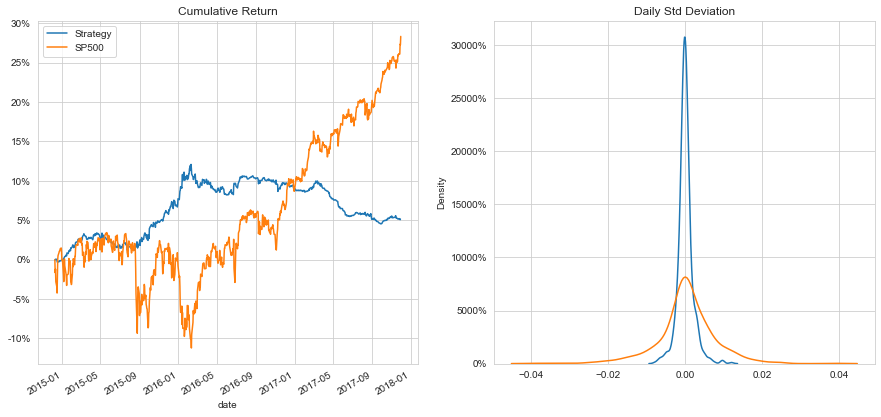

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 7))
strategy.join(sp500).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(sp500, ax=axes[1], hist=False, label='SP500')
axes[1].set_title('Daily Std Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _:'{:.0%}'.format(y)))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _:'{:.0%}'.format(y)))

pd.concat([strategy.join(sp500).add(1).cumprod().sub(1).idxmax(), strategy.join(sp500).add(1).cumprod().sub(1).max()],axis=1)

# not enough backtest in terms of look-ahead bias, trading costs, and risk mgmt
# thus, event-driven backtest is required

In [11]:
res = strategy.join(sp500).dropna()
res.std()

Strategy    0.001986
SP500       0.007923
dtype: float64

In [12]:
res.corr()

,Strategy,SP500
Strategy,1.000000,-0.088602
SP500,-0.088602,1.000000
